<a href="https://colab.research.google.com/github/Baeji1/Level-Set/blob/master/Image_Test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Set path to directory


In [45]:
%cd ./drive/My\ Drive
%pwd

'/content/drive/My Drive'

### Imports


In [46]:
%matplotlib inline
from matplotlib import pyplot as plt
import time
import os
import cv2 as cv
import numpy as np
import keras
from IPython.display import display, clear_output
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten
from keras.optimizers import Adam
from keras.layers import Conv2D, UpSampling2D, InputLayer, Conv2DTranspose
from keras.layers import Activation, Dense, Dropout, Flatten
from keras.layers.normalization import BatchNormalization
cv.__version__

'4.1.2'

### Image Format Functions and Callbacks



In [0]:
def offsetROI(offset,img):
  x1,y1 = 155,68
  x2,y2 = 411,372
  roi = img[y1+offset[1]:y2+offset[3],x1+offset[0]:x2+offset[2]]
  return roi

def showMe(img,title):
  plt.imshow(img.astype(np.uint8))
  plt.title(title)
  plt.show()
  print(img.shape)
  return

def convertTime(time):
  day = time // (24 * 3600)
  time = time % (24 * 3600)
  hour = time // 3600
  time %= 3600
  minutes = time // 60
  time %= 60
  seconds = time
  time = "{:.0f}d :{:.0f}h :{:.0f}m :{:.0f}s".format(day, hour, minutes, seconds)
  return time


class PrintLogs(keras.callbacks.Callback):
  def __init__(self, epochs):
    self.epochs = epochs
    self.wait_dict = {}
    self.wait_dict['clear_iterations'] = 100
    self.wait_dict['print_iterations'] = 10
    self.wait_dict['track_time'] = 0
  
  def set_params(self, params):
    params['epochs'] = 0

  def on_epoch_begin(self, epoch, logs=None):
    if(epoch +1)%self.wait_dict['clear_iterations'] == 0:
      clear_output(wait=True)
    
    if(epoch +1)%self.wait_dict['print_iterations'] == 0:
      print('Epoch %d/%d' % (epoch + 1, self.epochs),end=' ')
    
    self.wait_dict['track_time'] = time.time()
  
  def on_epoch_end(self, epoch, logs=None):
    self.wait_dict['track_time'] = time.time() - self.wait_dict['track_time']

    if(epoch+1)%self.wait_dict['print_iterations'] == 0:
      print(' Loss: {:.3f}   Time: {:.3f}'.format(logs['loss'],self.wait_dict['track_time']))


### Image Test


In [48]:
# img_path = 'test_image.jpg'
# img = cv.imread(img_path)

original = offsetROI([0,0,0,0],img)
# showMe(original,'Original')

x_offset = 337
contour = offsetROI([x_offset,0,x_offset,0],img)
# showMe(contour,'Contour')

y_offset = 425
nucleus = offsetROI([x_offset,y_offset,x_offset,y_offset],img)
# showMe(nucleus,'Nucleus')

print(' Loaded all sub-images with shape {}\n\n'.format(original.shape))

 Loaded all sub-images with shape (304, 256, 3)




### Model


In [0]:
def nucleus_model(input_shape):
  model = Sequential()
  model.add(InputLayer(input_shape=input_shape))
  model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
  model.add(Conv2D(32, (3, 3), activation='relu', padding='same', strides=2))
  model.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
  model.add(Conv2D(16, (3, 3), activation='relu', padding='same', strides=2))
  model.add(Conv2D(8, (3, 3), activation='relu', padding='same', strides=2))
  model.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
  model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
  model.add(UpSampling2D((2, 2)))
  model.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
  model.add(UpSampling2D((2, 2)))
  model.add(Conv2D(3, (3, 3), activation='tanh', padding='same'))
  return model


### Training


In [50]:
(x_train,y_train),(x_test,y_test) = (original,nucleus),(original,nucleus)
(x_train,y_train),(x_test,y_test) = (x_train/255,y_train/255),(x_test/255,y_test/255)

input_shape = x_train.shape
x_train = np.array([x_train])
y_train = np.array([y_train])
centroidModel = nucleus_model(input_shape)
centroidModel.compile(optimizer='adam',loss='mse',metrics=['accuracy'])
centroidModel.summary()

start_time = time.time()

epochs = 100
batch_size = 1

# centroidModel.fit(x=x_train, 
#     y=x_train,
#     batch_size=batch_size,
#     epochs=epochs,
#     verbose=0,
#     callbacks=[PrintLogs(epochs)])

end_time = time.time()
print(' Training start time: {}\n'.format(time.ctime(start_time)))
print(' Training end time: {}\n'.format(time.ctime(end_time)))
total = convertTime(end_time-start_time)
print(' Total training time: {} \n'.format(total))


Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_100 (Conv2D)          (None, 304, 256, 32)      896       
_________________________________________________________________
conv2d_101 (Conv2D)          (None, 152, 128, 32)      9248      
_________________________________________________________________
conv2d_102 (Conv2D)          (None, 152, 128, 16)      4624      
_________________________________________________________________
conv2d_103 (Conv2D)          (None, 76, 64, 16)        2320      
_________________________________________________________________
conv2d_104 (Conv2D)          (None, 38, 32, 8)         1160      
_________________________________________________________________
conv2d_105 (Conv2D)          (None, 38, 32, 8)         584       
_________________________________________________________________
conv2d_106 (Conv2D)          (None, 38, 32, 32)      

### Output

 Training time: 0d :0h :0m :0s
 Training Results:


 Prediction shape: (1, 152, 128, 3)



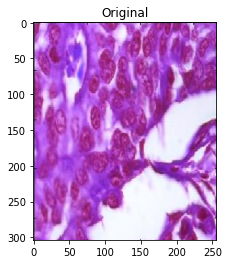

(304, 256, 3)


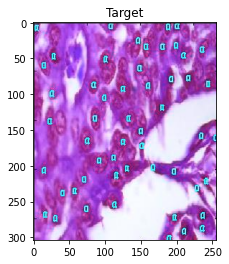

(304, 256, 3)


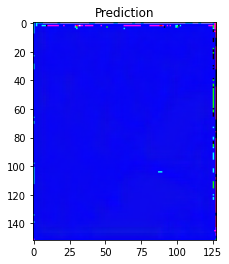

(152, 128, 3)


In [51]:
prediction = centroidModel.predict(x_train)
print(' Training time: {}'.format(total))
print(' Training Results:\n\n')
print(f' Prediction shape: {prediction.shape}\n')

prediction *= 255

showMe(original,'Original')
showMe(nucleus,'Target')
showMe(prediction[0],'Prediction')

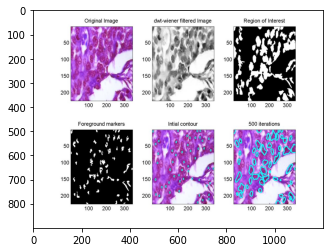

(900, 1200, 3)


In [0]:
plt.imshow(img)
plt.show()
print(img.shape)
